# <a href="http://gdeltproject.org/">GDELT</a> Events analysis

<ul>
    <li><a href="#Data-loading">Data loading</a></li>
    <li><a href="#Actors-analysis">Actors analysis</a></li>
        <ul>
            <li><a href="#What-type-of-actors-are-there?">What type of actors are there?</a></li>
            <li><a href="#Which-exactly-actors-are-there?">Which exactly actors are there?</a></li>
            <li><a href="#Pairwise-interactions-between-actors">Pairwise interactions between actors</a></li>
            <li><a href="#Interactions-mapping">Interactions mapping</a></li>
        </ul>
    <li><a href="#Actions-analysis">Actions analysis</a></li>
</ul>

In [1]:
import os
import pandas as pd

## Data loading

In [2]:
PATH = "data/"
df = pd.read_pickle(os.path.join(PATH, '2016.08.10_10.00-2016.08.10_12.00_export.pkl'))

## Actors analysis

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### What type of actors are there?

In [4]:
# define types of both actors
both_actor_types = pd.concat([df.Actor1Type1Code, df.Actor2Type1Code])
types_labels = both_actor_types.value_counts().keys()
tupes_counts = both_actor_types.value_counts().values

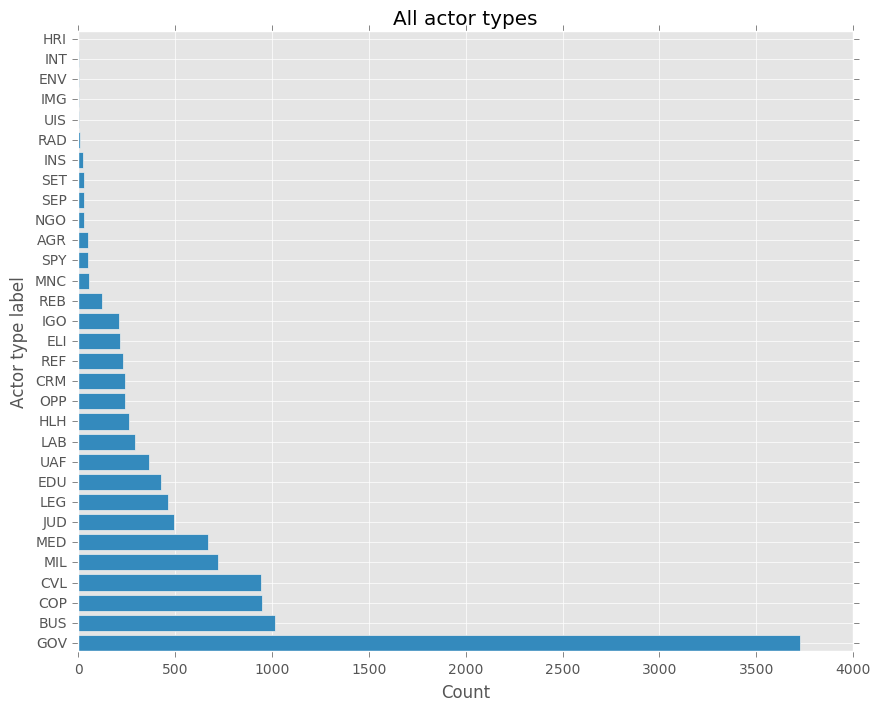

In [5]:
# visualizing both actor types
plt.figure(figsize=(10,8))
plt.yticks(range(len(types_labels)), types_labels)
plt.barh(range(len(tupes_counts)), tupes_counts, align='center')
plt.title('All actor types')
plt.ylabel('Actor type label')
plt.xlabel('Count')
plt.show()

### Which exactly actors are there?

In [6]:
# the plot shows that the actors with the GOV-type are clearly dominated
# thus let's consider in more detail this particular group
both_actors = pd.concat(
    [df.Actor1CountryCode[df.Actor1Type1Code == 'GOV'],
     df.Actor2CountryCode[df.Actor2Type1Code == 'GOV']]
)
labels = both_actors.value_counts().keys()
sizes = both_actors.value_counts().values

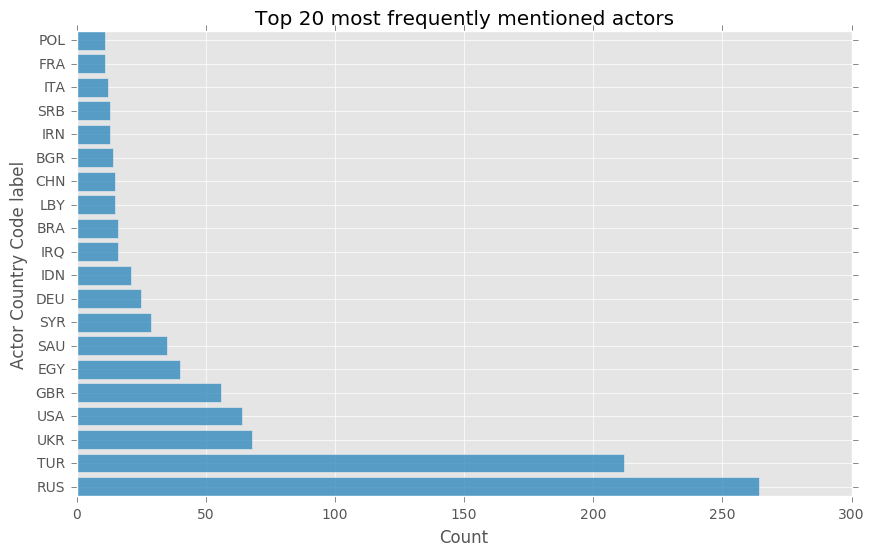

In [7]:
# visualizing 20 most frequent actors
plt.figure(figsize=(10,6))
plt.yticks(range(len(labels[0:20])), labels[0:20])
plt.barh(range(len(sizes[0:20])), sizes[0:20], align='center', alpha=0.8)
plt.ylabel('Actor Country Code label')
plt.xlabel('Count')
plt.title('Top 20 most frequently mentioned actors')
plt.show()

### Pairwise interactions between actors

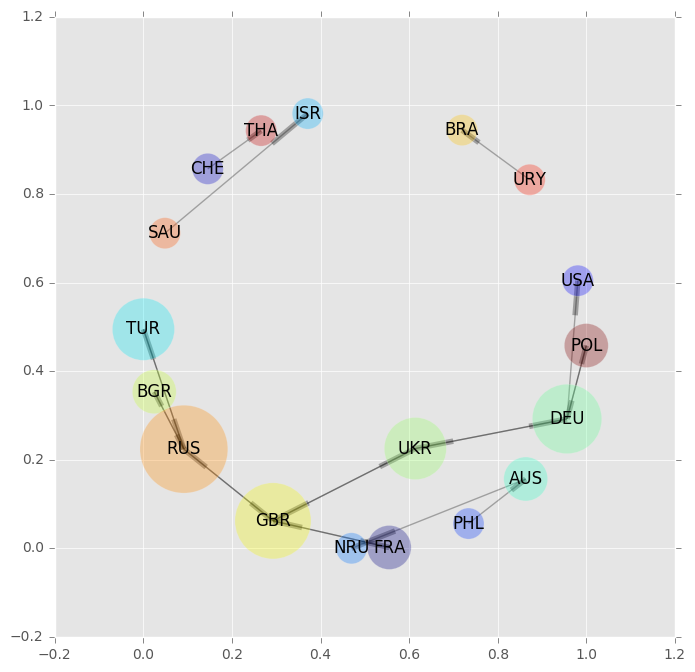

In [8]:
# visualizing interactions between Actors
import networkx as nx

# subset events with GOV-type Actors only
cols_list = ['Actor1CountryCode','Actor2CountryCode','QuadClass', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']
subset = df[cols_list][(df.Actor1Type1Code == 'GOV') & (df.Actor2Type1Code == 'GOV')].dropna()

# create directed graph
G=nx.from_pandas_dataframe(
    subset, 
    source='Actor1CountryCode', 
    target='Actor2CountryCode', 
    create_using=nx.DiGraph()
)
# node size dependent on the node degree
degree = G.degree()
nodesize = [v * 500 for v in degree.values()] # its necessary for persistence order of nodes
nodelist= [v for v in degree.keys()] # its necessary for persistence order of nodes
pos=nx.spring_layout(G)
plt.figure(figsize=(8,8))
nx.draw_networkx(G, pos=pos, node_color=range(len(G)), alpha=0.3,node_size=nodesize, nodelist=nodelist)

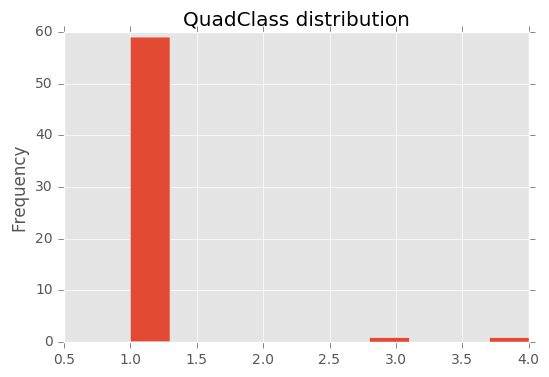

In [9]:
# what kind of interactions occur between actors
# 1 - Verbal Cooperation
# 2 - Material Cooperation
# 3 - Verbal Conflict
# 4 - Material Conflict
subset.QuadClass.astype(int).plot.hist(title='QuadClass distribution')

### Interactions mapping

In [10]:
from mpl_toolkits.basemap import Basemap
from collections import defaultdict

def map_configure(*arg, **kwargs):
    m = Basemap(*arg, **kwargs)
    m.drawmapboundary()
    m.fillcontinents(color='0.8')
    m.drawcoastlines()
    m.drawcountries()
    return m

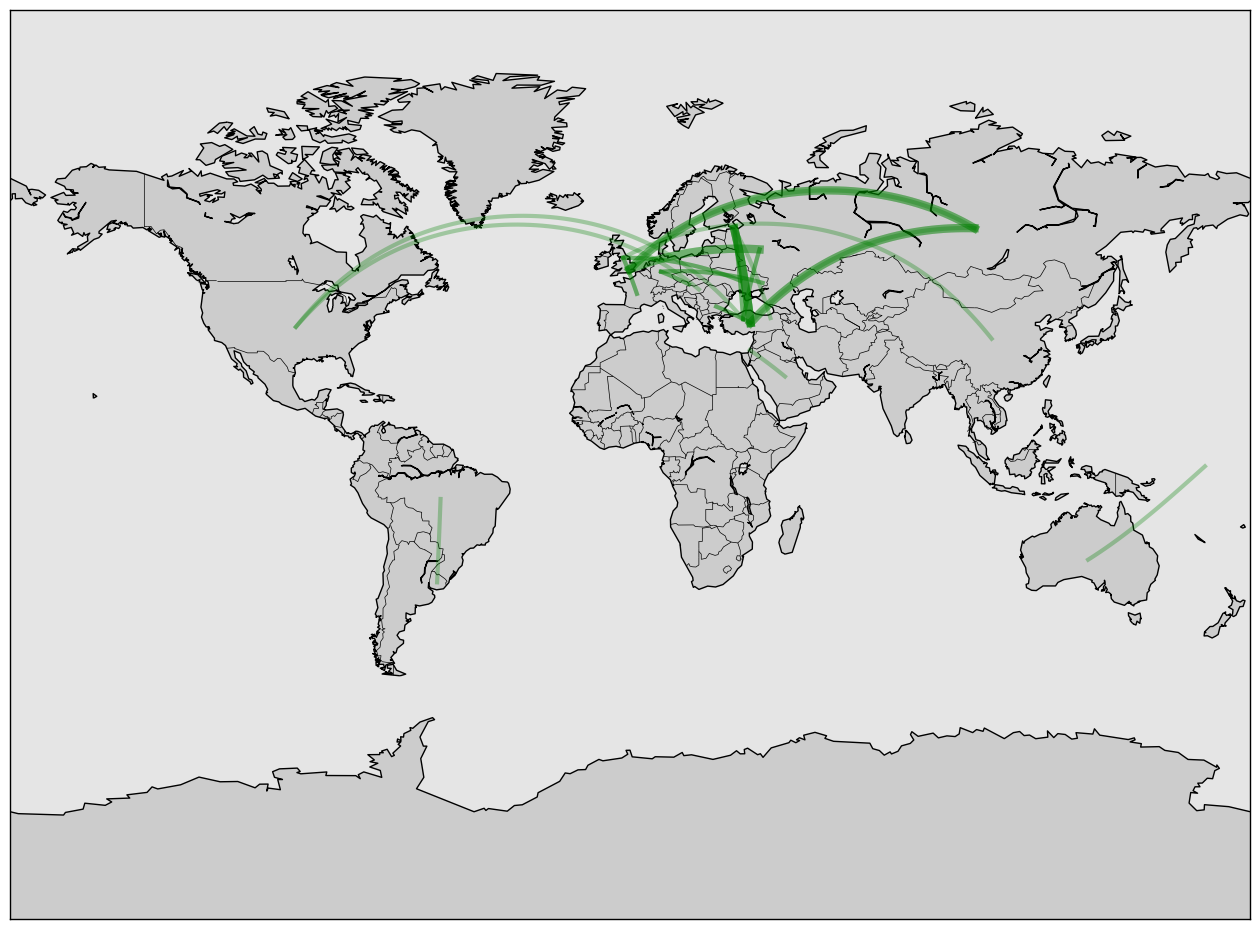

In [11]:
# define counts of interactions
interactions = defaultdict(int)
for x1, x2, y1, y2 in subset[['Actor1Geo_Long','Actor2Geo_Long', 'Actor1Geo_Lat', 'Actor2Geo_Lat']].astype(float).values:
    interactions[((x1,y1),(x2,y2))] += 1

# draw map
plt.figure(figsize=(16,16))
m = map_configure(projection='mill')
# color for interaction based on QuadClass value
quad_colors = {1.0: 'g', 2.0: 'y', 3.0: 'b', 4.0: 'r'}

# draw interactions
for x1, x2, y1, y2, q in subset[['Actor1Geo_Long','Actor2Geo_Long', 'Actor1Geo_Lat', 'Actor2Geo_Lat', 'QuadClass']].astype(float).values:
    m.drawgreatcircle(x1, y1,x2, y2,linewidth=interactions[((x1,y1),(x2,y2))]*3, color=quad_colors[q], alpha=0.3)
plt.show()

## Actions analysis

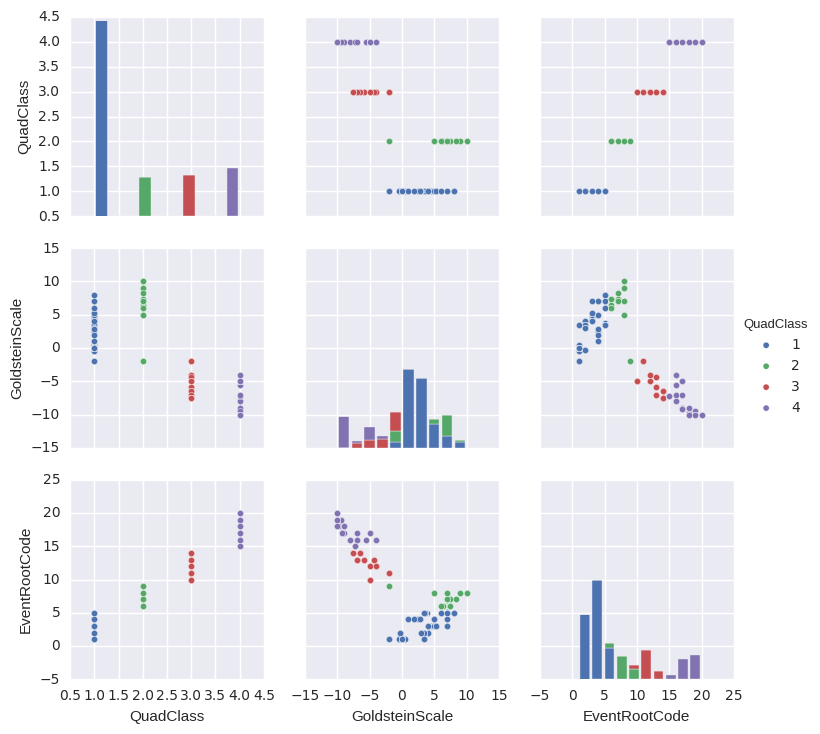

In [12]:
# event action attributes which responsible for type of concrete event are following: 
#'EventCode' ('EventBaseCode','EventRootCode'), 'QuadClass', 'GoldsteinScale'
# so let's take a look at relations between this attributes

import seaborn as sns
sns.pairplot(df[["QuadClass","GoldsteinScale", "EventRootCode"]].apply(pd.to_numeric), hue='QuadClass')

In [13]:
### interpretation of the plot ###

# there is very strong correlation between QuadClass and EventRootCode.
# it means that EventRootCode from 01 to 05 corresponds to QuadClass 1,
# from EventRootCode 06 to 10 corresponds to QuadClass 2, etc.

# GoldsteinScale have a some correlation with QuadClass and EventRootCode,
# if GoldSteinScore < 0  then QuadClass = 3 or 4 and EventRootCode from 10 to 20
# if GoldSteinScore >= 0 then QuadClass = 1 or 2 and EventRootCode from 01 to 09


# so it is useful to consider QuadClass as classification criterion,
# as it has only four intuitively clear values

In [14]:
def mapping_events(data, scaling=False, *args, **kwargs):
    # define actions count
    actions = defaultdict(int)
    for x, y, q in data.astype(float).values:
        actions[(x,y,q)] += 1

    # define max/min value of action counts for scaling purpose
    min_counts = min(actions.values())
    max_counts = max(actions.values())
    scale_factor = 30.0

    # drawing map
    m = map_configure(*args, **kwargs)

    # drawing action points
    for point, count in actions.iteritems():
        x, y = m(point[0], point[1])
        if scaling:
            size = (float(count - min_counts) / (max_counts - min_counts)) * scale_factor # scaling counts
        else:
            size = 5        
        m.plot(x,y, marker='o', markersize=size, alpha=0.5, color=quad_colors[point[2]])

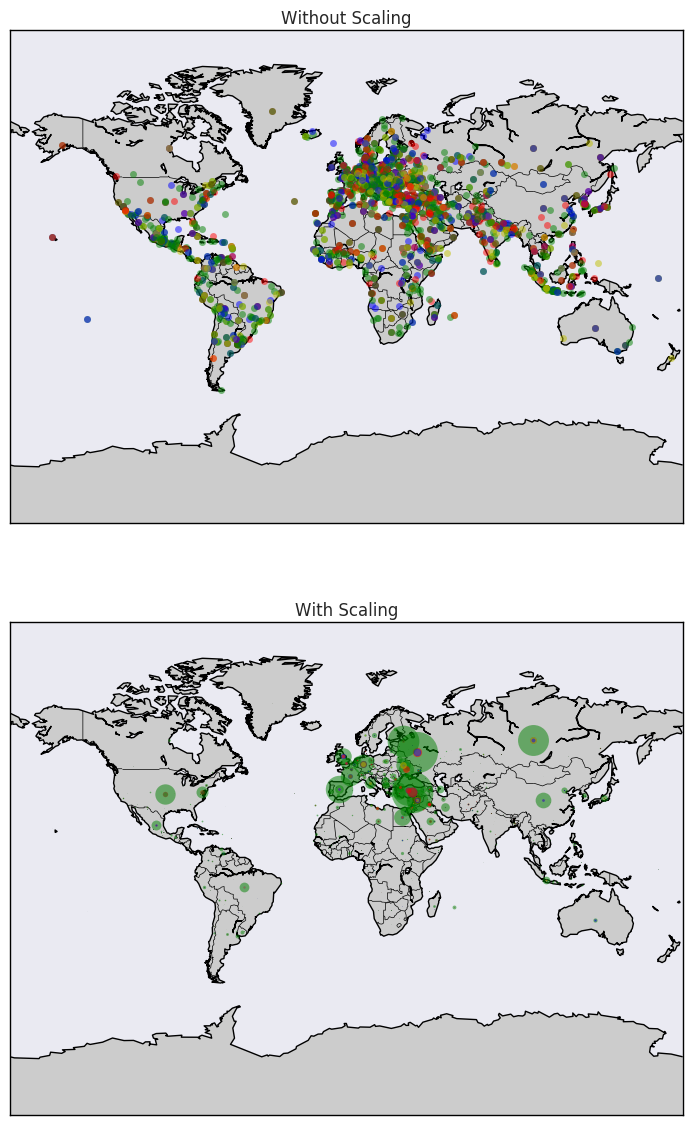

In [15]:
action_subset = df[['ActionGeo_Long', 'ActionGeo_Lat', 'QuadClass']].dropna()

# plotting map with and without action count scaling
f = plt.figure(figsize=(14,14))

ax = f.add_subplot(211)
ax.set_title("Without Scaling")
mapping_events(action_subset, scaling=False, projection='mill')

ax = f.add_subplot(212)
ax.set_title("With Scaling")
mapping_events(action_subset, scaling=True, projection='mill')

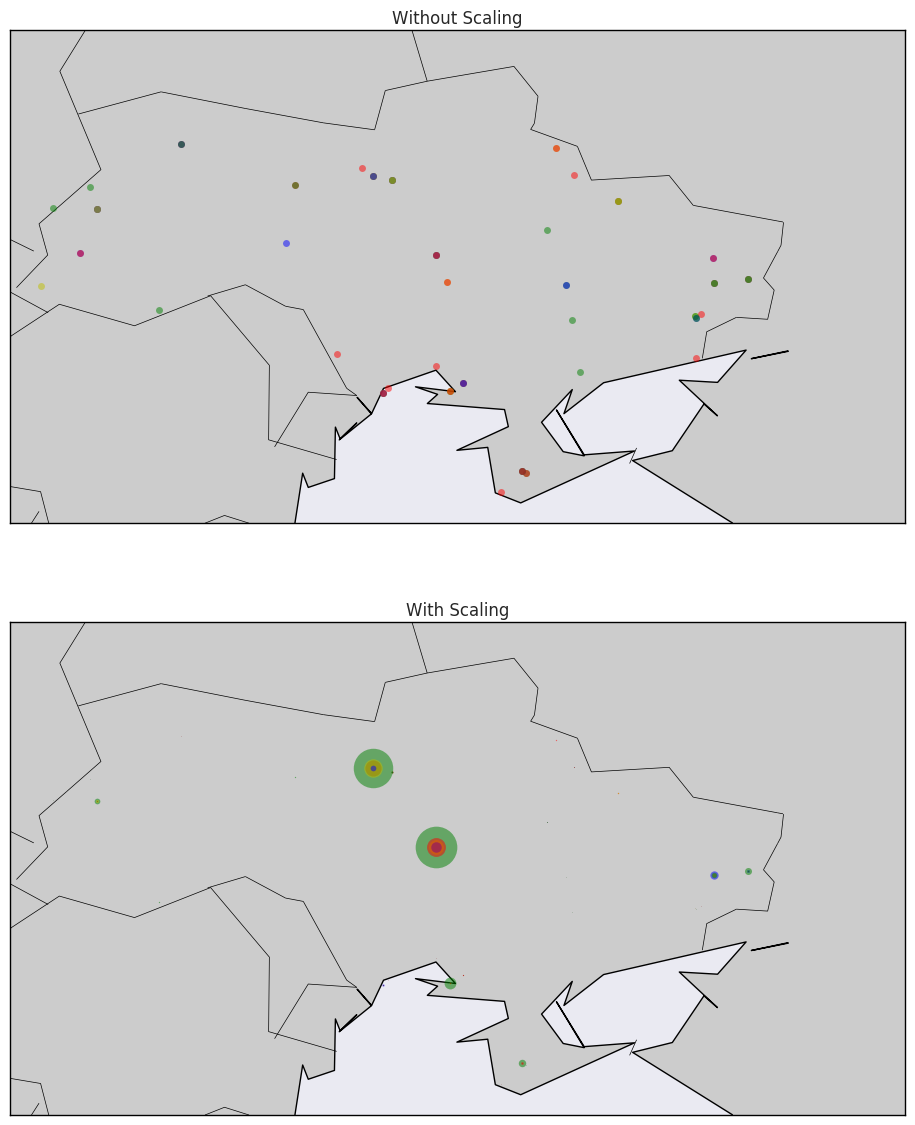

In [16]:
# filtering by country
action_subset_country = df[['ActionGeo_Long', 'ActionGeo_Lat', 'QuadClass']][df.ActionGeo_FullName.str.contains('Ukraine') == True].dropna()

# plotting map with and without action count scaling
f = plt.figure(figsize=(16,14))

ax = f.add_subplot(211)
ax.set_title("Without Scaling")
mapping_events(action_subset_country, scaling=False, projection='mill', 
                    lat_0 = 48.0, lon_0=32.0, # Map center 
                    llcrnrlon=22, llcrnrlat=44, # Lower left corner
                    urcrnrlon=43, urcrnrlat=53)

ax = f.add_subplot(212)
ax.set_title("With Scaling")
mapping_events(action_subset_country, scaling=True, projection='mill', 
                    lat_0 = 48.0, lon_0=32.0, # Map center 
                    llcrnrlon=22, llcrnrlat=44, # Lower left corner
                    urcrnrlon=43, urcrnrlat=53)